# Import modules

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
# ========== STEP 1: Load and Preprocess Data ==========

def preprocess_csi_for_1dcnn(data):
    X = []
    for i in range(data.shape[2]):
        sample = np.abs(data[:, :, i])
        norm = sample / (sample[0:1, :] + 1e-8)
        flat = norm.T.flatten()
        X.append(flat)
    return np.array(X)

presence = np.load('dataset_SDR/dataPresence.npy')
no_presence = np.load('dataset_SDR/NoPresence.npy')
small_presence = np.load('dataset_SDR/dataSmallPresence.npy')

X_presence = preprocess_csi_for_1dcnn(presence)
X_no_presence = preprocess_csi_for_1dcnn(no_presence)
X_small_presence = preprocess_csi_for_1dcnn(small_presence)

# Labels: 0 - presence, 1 - no presence, 2 - small presence
y_presence = np.full((X_presence.shape[0],), 0)
y_no_presence = np.full((X_no_presence.shape[0],), 1)
y_small_presence = np.full((X_small_presence.shape[0],), 2)

X = np.vstack([X_presence, X_no_presence, X_small_presence])
y = np.concatenate([y_presence, y_no_presence, y_small_presence])

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split 70% train, 15% val, 15% test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=42)
# Note: 0.1765 of 85% ≈ 15%

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (900, 416), Val: (300, 416), Test: (300, 416)


In [3]:
# ========== STEP 2: Dataset & DataLoader ==========

class CSIDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = CSIDataset(X_train, y_train)
val_dataset = CSIDataset(X_val, y_val)
test_dataset = CSIDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)


In [4]:
# ========== STEP 3: 1D CNN Model ==========

class CSI1DCNN(nn.Module):
    def __init__(self):
        super(CSI1DCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=5)
        self.pool1 = nn.MaxPool1d(2)
        self.dropout = nn.Dropout(0.3)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3)
        self.pool2 = nn.MaxPool1d(2)
        self.dropout = nn.Dropout(0.3)

        dummy_input = torch.zeros(1, 1, 416)
        out = self.pool2(self.conv2(self.pool1(self.conv1(dummy_input))))
        self.flattened_size = out.view(1, -1).shape[1]

        self.fc1 = nn.Linear(self.flattened_size, 64)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, 3)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [5]:
# ========== STEP 4: Train Loop ==========

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model = CSI1DCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train_acc_history = []
val_acc_history = []
train_loss_history = []
val_loss_history = []

print("Training with validation...\n")
for epoch in range(30):
    start = time.time()
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)

    train_acc = train_correct / train_total
    train_acc_history.append(train_acc)
    train_loss_history.append(train_loss)

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    val_acc_history.append(val_acc)
    val_loss_history.append(val_loss)

    print(f"Epoch {epoch+1:2d} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Loss: {train_loss:.4f} | Time: {time.time()-start:.2f}s")

Using device: cuda
Training with validation...

Epoch  1 | Train Acc: 0.3467 | Val Acc: 0.3467 | Loss: 36.5675 | Time: 2.50s
Epoch  2 | Train Acc: 0.5500 | Val Acc: 0.5600 | Loss: 26.3502 | Time: 0.08s
Epoch  3 | Train Acc: 0.8278 | Val Acc: 0.8933 | Loss: 12.3629 | Time: 0.09s
Epoch  4 | Train Acc: 0.9200 | Val Acc: 0.9700 | Loss: 6.6407 | Time: 0.08s
Epoch  5 | Train Acc: 0.9733 | Val Acc: 0.9733 | Loss: 3.0758 | Time: 0.08s
Epoch  6 | Train Acc: 0.9611 | Val Acc: 0.9767 | Loss: 3.4741 | Time: 0.08s
Epoch  7 | Train Acc: 0.9644 | Val Acc: 0.9867 | Loss: 2.6651 | Time: 0.09s
Epoch  8 | Train Acc: 0.9856 | Val Acc: 0.9733 | Loss: 1.5725 | Time: 0.08s
Epoch  9 | Train Acc: 0.9778 | Val Acc: 0.9200 | Loss: 2.2740 | Time: 0.09s
Epoch 10 | Train Acc: 0.9556 | Val Acc: 0.9767 | Loss: 5.5282 | Time: 0.08s
Epoch 11 | Train Acc: 0.9411 | Val Acc: 0.9467 | Loss: 4.5996 | Time: 0.08s
Epoch 12 | Train Acc: 0.9789 | Val Acc: 0.9767 | Loss: 2.1727 | Time: 0.08s
Epoch 13 | Train Acc: 0.9778 | Val Ac


 Test Accuracy: 0.9867


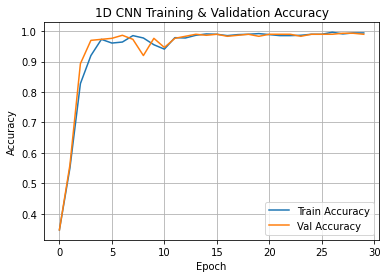

In [6]:
# ========== STEP 5: Evaluate ==========

model.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print(f"\n Test Accuracy: {correct / total:.4f}")

# ========== STEP 6: Plot Accuracy ==========

plt.figure()
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Val Accuracy')
plt.title('1D CNN Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()


 Test Accuracy: 0.9867

 Classification Report:
                precision    recall  f1-score   support

      Presence       0.98      0.98      0.98       100
   No Presence       1.00      1.00      1.00       100
Small Presence       0.98      0.98      0.98       100

      accuracy                           0.99       300
     macro avg       0.99      0.99      0.99       300
  weighted avg       0.99      0.99      0.99       300



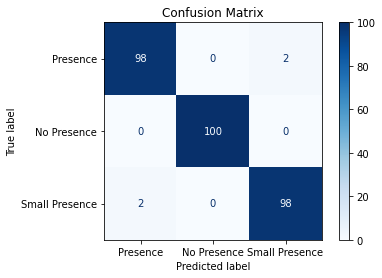

In [7]:
# ========== STEP 5: Evaluate & Report ==========

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"\n Test Accuracy: {accuracy:.4f}")

# Classification report
print("\n Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['Presence', 'No Presence', 'Small Presence']))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Presence', 'No Presence', 'Small Presence'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()